In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os

# Прогнозирование курса рубля в зависимости от цен на нефть

## Обзор цен на нефть

Выгрузим данные нефтяных котировок. Посмотрим и оценим масштаб работ.

In [2]:
crude_oil = pd.read_csv('data/brent-daily_csv-2.csv')

In [3]:
crude_oil.head()

,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [4]:
price_series_oil = crude_oil["Price"]
price_series_oil.head(10)

## Учет PPI

Дисконтируем исходный временной ряд нефтяных цен по PPI. Где PPI - показатель среднего уровня изменения цен на сырьё, материалы и товары промежуточного потребления относительно базисного периода. Используется для пересчета в сопоставимые цены максимально детализированных компонентов ВНП.


Ниже запишем итоговую формулу

$$
    OIL_{disc} = \frac{OIL_{t}}{PPI_{t}}
$$

Прочитаем данные по PPI

In [5]:
ppi_data = pd.read_csv('data/PPI.csv')

In [6]:
ppi_data.head()

,Date,PPI
0,1913-01-01,12.1
1,1913-02-01,12.0
2,1913-03-01,12.0
3,1913-04-01,12.0
4,1913-05-01,11.9


In [7]:
oil_prices_with_ppi = crude_oil.copy()

In [8]:
ppi_data["Date"][0][0:7]

'1913-01'

Дисконтируем нефтяные котировки по PPI

In [9]:
for i in range(0, len(oil_prices_with_ppi)):
    for j in range(0, len(ppi_data)):
        if oil_prices_with_ppi["Date"][i].find(ppi_data["Date"][j][:7]) != -1:
            oil_prices_with_ppi["Price"][i] = float(oil_prices_with_ppi["Price"][i] / ppi_data["PPI"][j])
    

<ipython-input-9-74cfe9090b13>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [10]:
oil_prices_with_ppi.head()

,Date,Price
0,1987-05-20,0.181579
1,1987-05-21,0.179825
2,1987-05-22,0.180799
3,1987-05-25,0.181287
4,1987-05-26,0.181579


In [11]:
oil_prices_with_ppi.describe()

,Price
count,8449.000000
mean,0.274473
std,0.141895
min,0.049164
25%,0.157713
50%,0.225815
75%,0.367009
max,0.700487


Изобразим дисконтированные цены для наглядности данных.

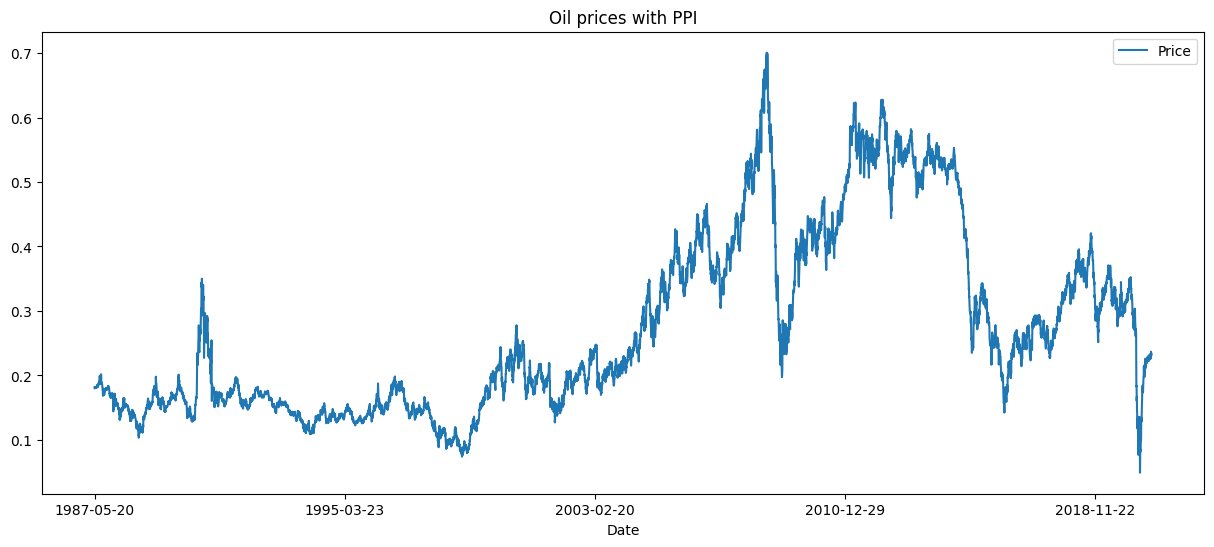

In [12]:
oil_prices_with_ppi_ind = oil_prices_with_ppi.set_index('Date')

oil_prices_with_ppi_ind.plot(figsize=(15, 6))
plt.title('Oil prices with PPI')
plt.show()

На всякий случай оценим логофрим предыдущего временного ряда. Может понадобиться в дальнейшем, так как логарифмированные зависимости могут иметь лучшую точность и помочь избавиться от несимметричности.

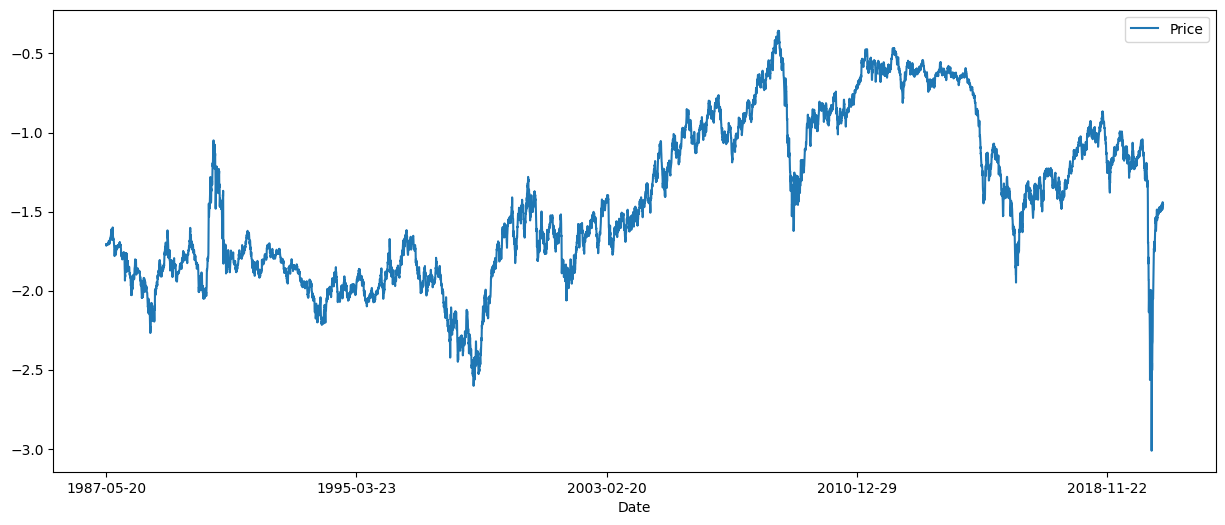

In [13]:
oil_prices_with_ppi_log = np.log(oil_prices_with_ppi_ind)

oil_prices_with_ppi_log.plot(figsize=(15, 6))
plt.show()

In [14]:
oil_prices_with_ppi_ind.head()

,Price
Date,
1987-05-20,0.181579
1987-05-21,0.179825
1987-05-22,0.180799
1987-05-25,0.181287
1987-05-26,0.181579


## Построение ARIMA модели

### Подбор параметра d(степень дифференцирования)

Здесь попытаемся подобрать необходимые параметры для модели предсказания цен на нефть с учетом PPI. Будем предсказывать логаримф, далее вернемся к исходным величинам.


Сначала поисследуем логарифмированный временной ряд на стационарность при помощи теста Дики-Фуллера. Подберем параметры для ARIMA на основании результатов.

In [15]:
from statsmodels.tsa.stattools import adfuller

'''
Тест Дики — Фуллера для проверки на стационарность 
'''
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(8,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -2.408014
p-value                           0.139487
#Lags Used                       31.000000
Number of Observations Used    8417.000000
Critical Value (1%)              -3.431127
Critical Value (5%)              -2.861883
Critical Value (10%)             -2.566953
dtype: float64


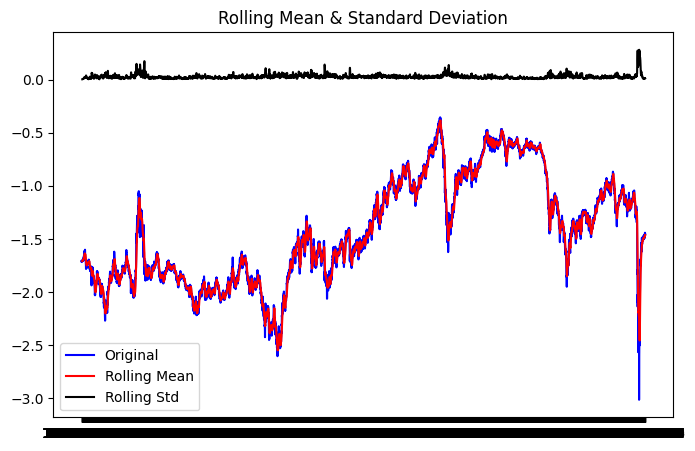

In [16]:
test_stationarity(oil_prices_with_ppi_log)

Превышено пороговое значение pvalue = 0.05, следовательно, о признании стационарным временным рядом пока говорить рано. Хотя это хорошо видно и без теста.

Самым простым способом добиться стационарности - это продифференцировать

In [17]:
# Продифференцируем 1 раз и запустим тест
oil_prices_with_ppi_log_diff = oil_prices_with_ppi_log.Price.diff()

In [18]:
oil_prices_with_ppi_log_diff.dropna(inplace=True)

Results of Dickey-Fuller Test:
Test Statistic                -1.607427e+01
p-value                        5.464650e-29
#Lags Used                     3.000000e+01
Number of Observations Used    8.417000e+03
Critical Value (1%)           -3.431127e+00
Critical Value (5%)           -2.861883e+00
Critical Value (10%)          -2.566953e+00
dtype: float64


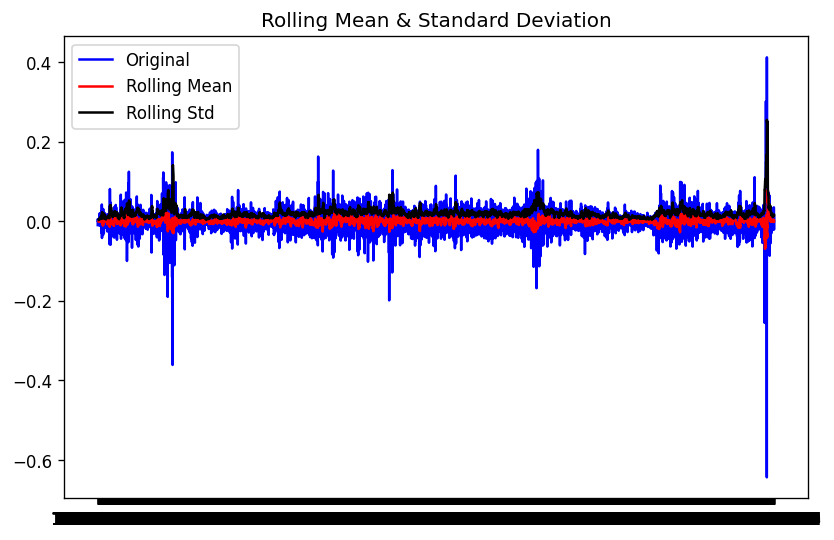

In [19]:
plt.rcParams.update({'figure.figsize':(8,5), 'figure.dpi':120})
test_stationarity(oil_prices_with_ppi_log_diff)

Здесь можно заметить, что первый порядок дифференцирования дает сильную ассимметрию и скользящее среднее не покрывает действительные значения, что говорит о избыточности дифференцирования.


Поэтому посмотрим на другие способы избавления от нестационарности.
Первым пусть будет скользящее среднее

In [20]:
moving_avg = oil_prices_with_ppi_log.rolling(window = 30).mean()
ts_log_moving_avg_diff = oil_prices_with_ppi_log.Price - moving_avg.Price

Results of Dickey-Fuller Test:
Test Statistic                -1.358691e+01
p-value                        2.071985e-25
#Lags Used                     2.800000e+01
Number of Observations Used    8.391000e+03
Critical Value (1%)           -3.431130e+00
Critical Value (5%)           -2.861885e+00
Critical Value (10%)          -2.566953e+00
dtype: float64


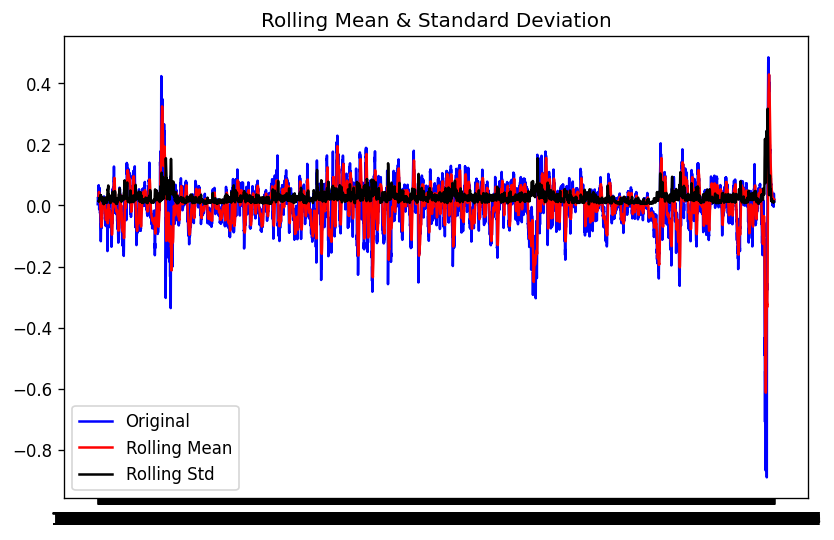

In [21]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

Результат уже неплохой, посмотрим еще несколько, может будет что-то получше. 

Например, взвешенное среднее.

In [22]:
ts_log = oil_prices_with_ppi_log

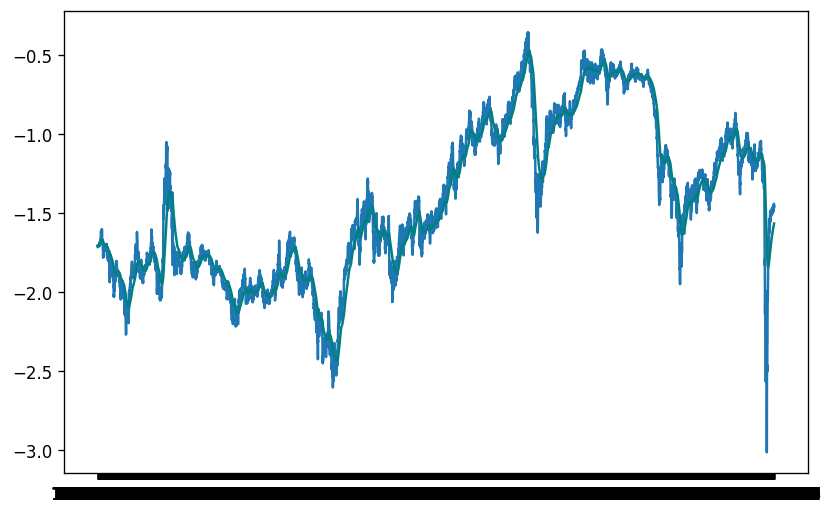

In [23]:
expwighted_avg = ts_log.ewm(halflife=30).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='Teal')

Results of Dickey-Fuller Test:
Test Statistic                -1.029401e+01
p-value                        3.509712e-18
#Lags Used                     2.900000e+01
Number of Observations Used    8.419000e+03
Critical Value (1%)           -3.431127e+00
Critical Value (5%)           -2.861883e+00
Critical Value (10%)          -2.566953e+00
dtype: float64


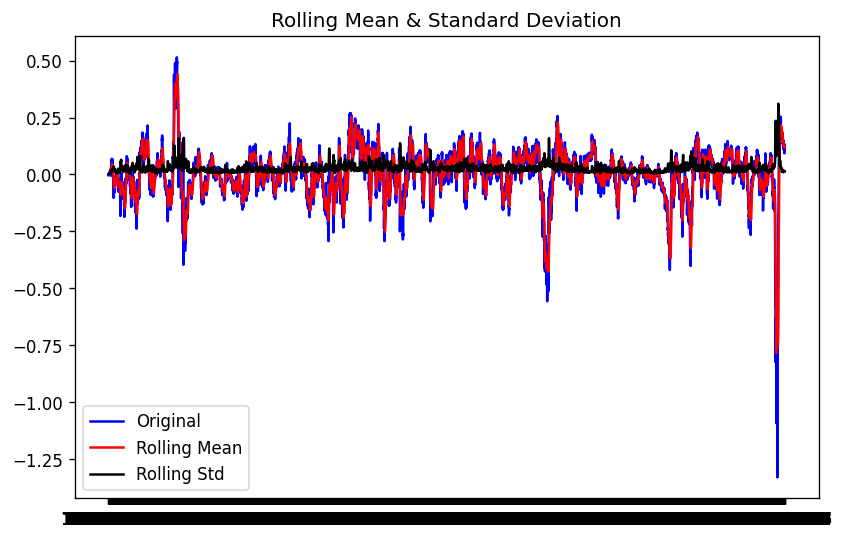

In [24]:
ts_log_ewma_diff = ts_log.Price - expwighted_avg.Price
test_stationarity(ts_log_ewma_diff)

Получилась слишком большая асимметрия, которую можно исправить некоторым смещением, но есть вариант, не требующий сторонних манипуляций: скользящее среднее(получили выше)

### Подбор параметра p

Подберем парметр p - на скольких предыдущих значениях будем строить предсказание. Построим графики функции частичной автокорреляции.

/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



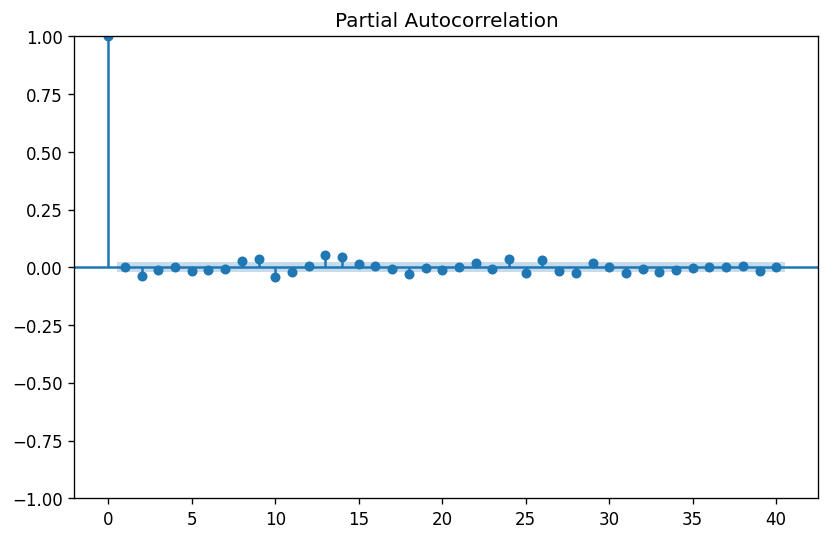

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# PACF plot of 1st differenced series
df = oil_prices_with_ppi_log_diff
plot_pacf(df.dropna(inplace=False))

plt.show()

Из-за малости большинства значений функции частичной автокорреляции, можно принять параметр p = 1. Первый lag имеет большее значение в соответствии с определенным уровнем

### Подбор параметра q

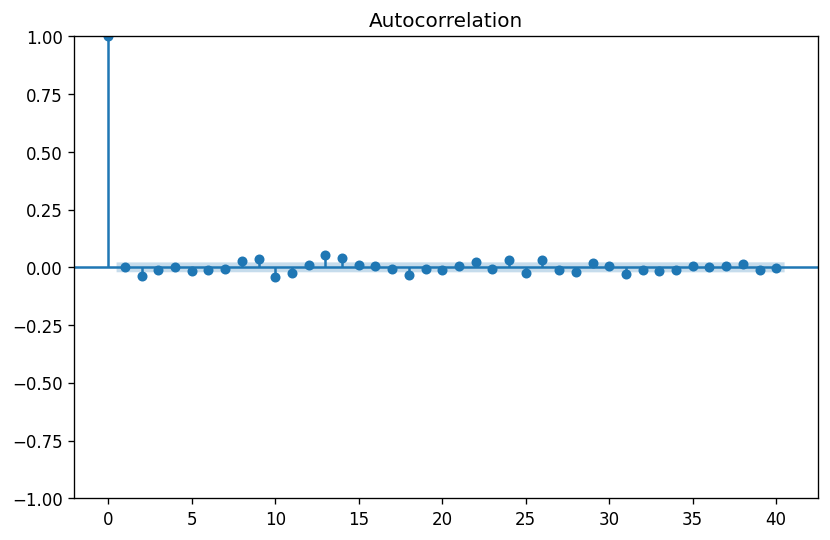

In [26]:
plot_acf(df.dropna())
plt.show()

По аналогичным соображениям примем параметр q = 1

## Тренировка и тестирование ARIMA

In [27]:
from statsmodels.tsa.arima_model import ARIMA

Еще раз для наглядности выведем логарифмированные котировки на нефть с учетом PPI

In [28]:
oil_prices_with_ppi_log.head()

,Price
Date,
1987-05-20,-1.706065
1987-05-21,-1.715774
1987-05-22,-1.710368
1987-05-25,-1.707676
1987-05-26,-1.706065


In [29]:
df = oil_prices_with_ppi_log

In [30]:
df.dropna(inplace=True)

In [31]:
### в датасете 8417 - отвечает за цены на нефть за июль 2020, их отнесем в тестовую часть
train = df[:8417]
test = df[8418:]

In [32]:
from statsmodels.tsa.arima.model import ARIMA

model_ = ARIMA(train, order=(1, 0, 1))

fitted = model_.fit()

/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [33]:
fc = fitted.forecast(31, alpha=0.05)

/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



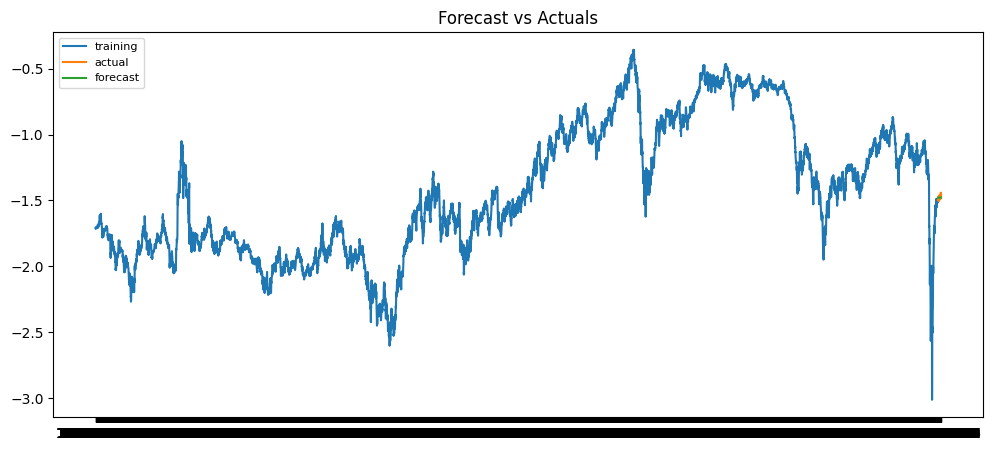

In [34]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [35]:
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 8417
Model:                 ARIMA(1, 0, 1)   Log Likelihood               18916.256
Date:                Tue, 23 Nov 2021   AIC                         -37824.512
Time:                        20:16:28   BIC                         -37796.360
Sample:                             0   HQIC                        -37814.900
                               - 8417                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4206      0.227     -6.261      0.000      -1.865      -0.976
ar.L1          0.9987      0.001   1811.111      0.000       0.998       1.000
ma.L1          0.0043      0.002      1.752      0.0

Выше содержится лог об ошибках, который в дальнейшем будет использован в отчете. Пока можем видеть незначительную ошибку, что позволяет считать, что предсказание котировок на июль 2020 года, достаточно точно.

In [36]:
fc

Вернемся к исходным данным, выполнив обратные преобразования

In [37]:
fc.index = test.index
np.exp(fc) * 193.2 # ppi за июль

Истинное значение цены на нефть в июле 2020 колебалось от 44 до 45.78 за баррель. Итого ошибка в нормальных значениях составляет 1-2 $


Теперь подберем модель парметры модели при помощи кросс-валидации

In [38]:
oil_prices_with_ppi.Price

In [39]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm



model = pm.auto_arima(oil_prices_with_ppi_log, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-37986.186, Time=11.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-37990.071, Time=1.93 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-37988.167, Time=1.48 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-37988.172, Time=11.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-37992.059, Time=1.00 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 26.756 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 8449
Model:               SARIMAX(0, 1, 0)   Log Likelihood               18997.030
Date:                Tue, 23 Nov 2021   AIC                         -37992.059
Time:                        20:16:56   BIC                         -37985.018
Sample:                             0   HQIC                        -37989.656
                               - 8449                          

Итого, лучшая модель SARIMA(p, d, q) = SARIMA(0, 1, 0). Но мы будем придерживаться превоначальной модели ARIMA, тк изначальная цель была в ее использовании

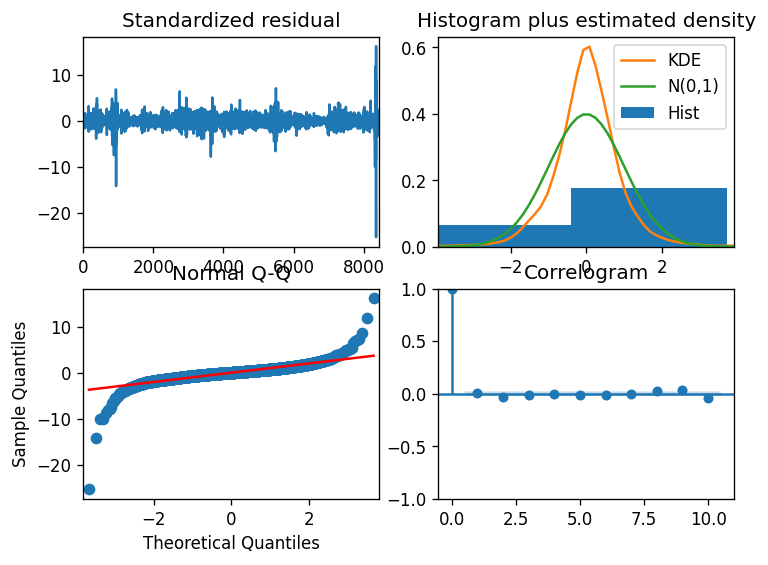

In [40]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

## Предсказание usd/rub по цене на нефть

In [41]:
usd_rub = pd.read_csv('data/USDRUB.csv')

In [42]:
cpi_rus = pd.read_csv('data/CPI_RUS.csv')

In [43]:
cpi_usa = pd.read_csv('data/CPI_USA.csv')

In [44]:
usd_rub.head()

,Date,USD/RUB
0,2020-12-30,74.6769
1,2020-12-29,73.7651
2,2020-12-28,73.7895
3,2020-12-25,74.1945
4,2020-12-24,73.9798


In [45]:
cpi_rus.head()

,Date,CPI
0,2010-01-01,101.64
1,2010-02-01,100.86
2,2010-03-01,100.63
3,2010-04-01,100.29
4,2010-05-01,100.50


In [46]:
cpi_usa.head()

,Date,CPI
0,2010-01-01,"217,488"
1,2010-02-01,"217,281"
2,2010-03-01,"217,353"
3,2010-04-01,"217,403"
4,2010-05-01,"217,29"


Пересчитаем курс usd/rub с учетом CPI

In [47]:
usd_rub_disc = usd_rub.copy()

for i in range(len(usd_rub) - 1, -1, -1):
    for j in range(0, len(cpi_usa)):
        if usd_rub["Date"][i].find(cpi_usa["Date"][j][:7]) != -1:
            usd_rub_disc["USD/RUB"][i] = usd_rub["USD/RUB"][i] * float(cpi_usa["CPI"][j].replace(',', '.')) / cpi_rus["CPI"][j]

<ipython-input-47-8ecee7592b8f>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [48]:
usd_rub_disc.head()

,Date,USD/RUB
0,2020-12-30,193.717048
1,2020-12-29,191.351776
2,2020-12-28,191.415071
3,2020-12-25,192.465669
4,2020-12-24,191.908722


In [49]:
usd_rub_disc = usd_rub_disc.reindex(index=usd_rub_disc.index[::-1])

In [50]:
usd_rub_disc_ind = usd_rub_disc.set_index('Date')

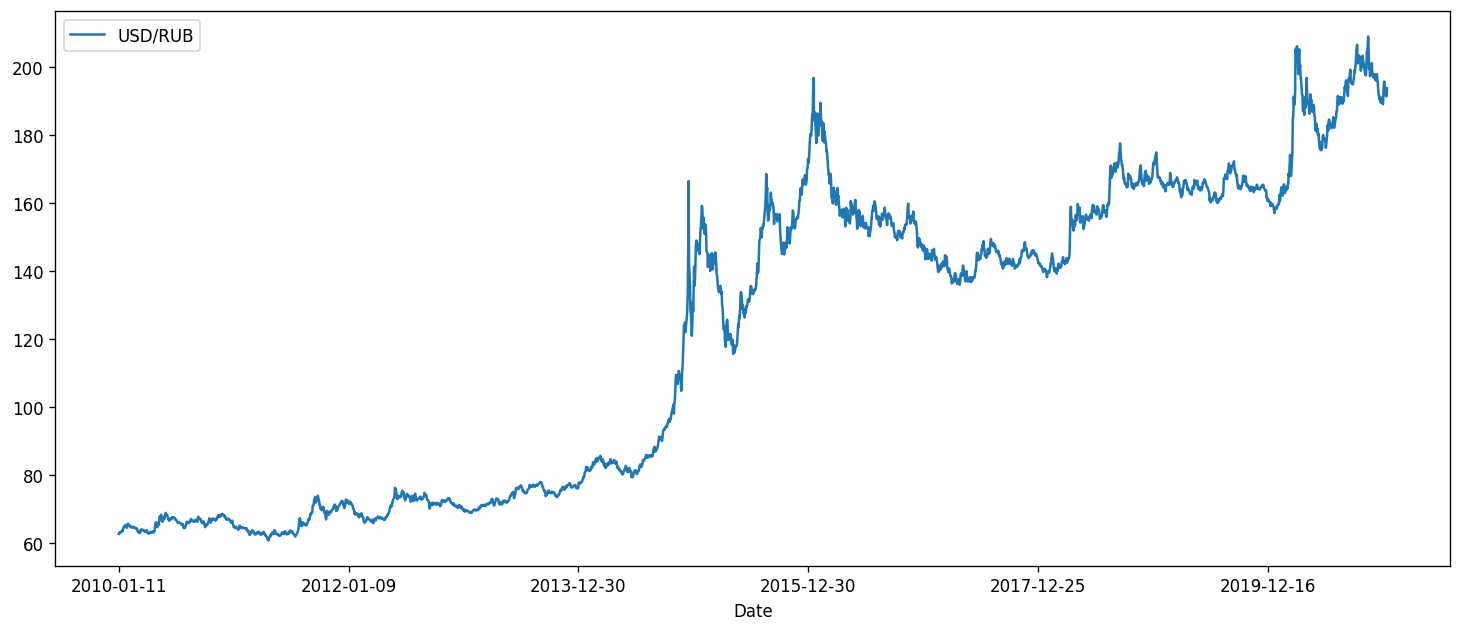

In [51]:
usd_rub_disc_ind.plot(figsize=(15, 6))
plt.show()

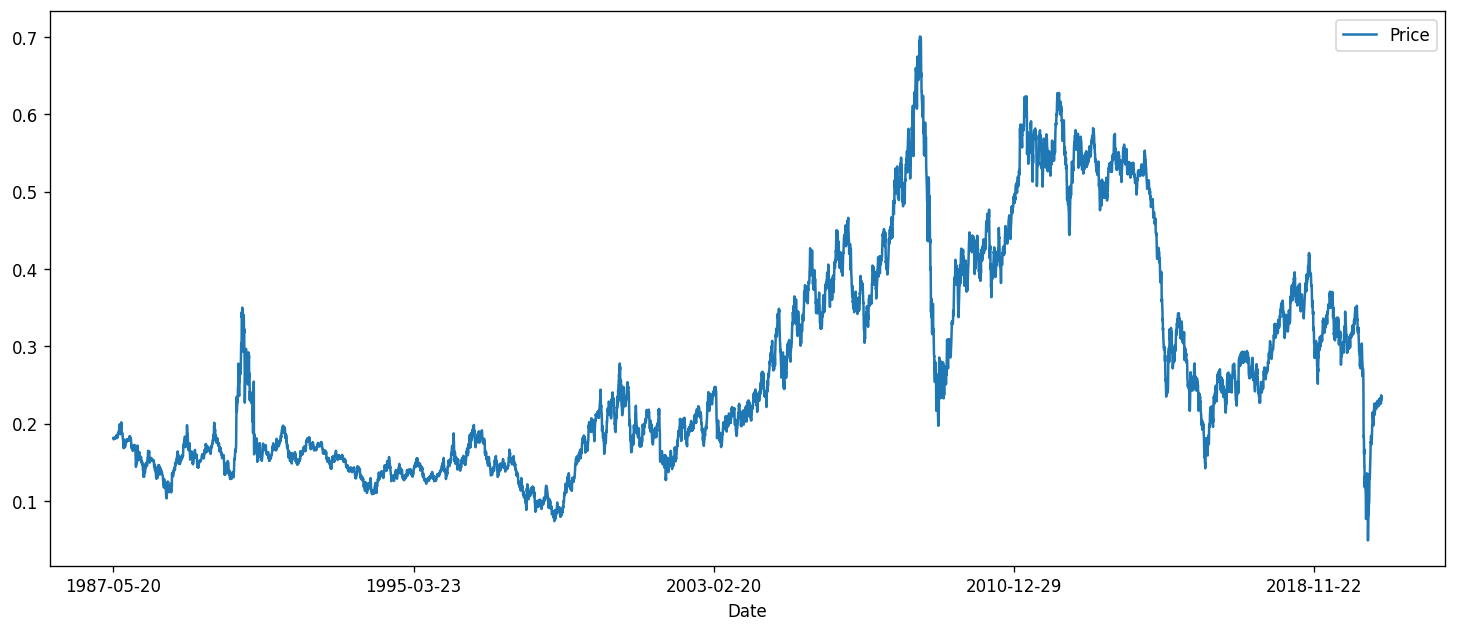

In [52]:
oil_prices_with_ppi_ind.plot(figsize=(15, 6))
plt.show()

In [53]:
aggr_oil_fx = usd_rub_disc.merge(oil_prices_with_ppi, left_on='Date', right_on='Date')

Агрегируем данные для удобства

In [54]:
aggr_oil_fx

,Date,USD/RUB,Price
0,2010-01-11,62.725516,0.440572
1,2010-01-12,63.099979,0.436394
2,2010-01-13,63.139565,0.426443
3,2010-01-14,63.019951,0.426663
4,2010-01-15,63.224515,0.422485
...,...,...,...
2585,2020-08-24,193.332580,0.228667
2586,2020-08-25,195.499585,0.236799
2587,2020-08-26,196.038026,0.235666
2588,2020-08-27,194.752673,0.230777


In [55]:
aggr_oil_fx["USD/RUB"].corr(aggr_oil_fx["Price"])

-0.89214517553471

Получили отрицательную корреляцию, значит увеличение значения обменного курса соответствует уменьшению нефтяных цен

In [56]:
x_train = np.array(aggr_oil_fx["Price"][::-1][31:].to_list()).reshape(-1, 1)
x_test = np.array(aggr_oil_fx["Price"][::-1][:30].to_list()).reshape(-1, 1)

y_train = np.array(aggr_oil_fx["USD/RUB"][::-1][31:].to_list())
y_test = np.array(aggr_oil_fx["USD/RUB"][::-1][:30].to_list())

In [57]:
(aggr_oil_fx[::-1])[:30]

,Date,USD/RUB,Price
2589,2020-08-28,192.578139,0.232733
2588,2020-08-27,194.752673,0.230777
2587,2020-08-26,196.038026,0.235666
2586,2020-08-25,195.499585,0.236799
2585,2020-08-24,193.332580,0.228667
2584,2020-08-21,194.130636,0.226145
2583,2020-08-20,192.359024,0.229336
2582,2020-08-19,189.905144,0.232681
2581,2020-08-18,190.237451,0.233350
2580,2020-08-17,190.754864,0.231137


Взглянем на прязнаковое пространство, чтобы получше угадать классификатор

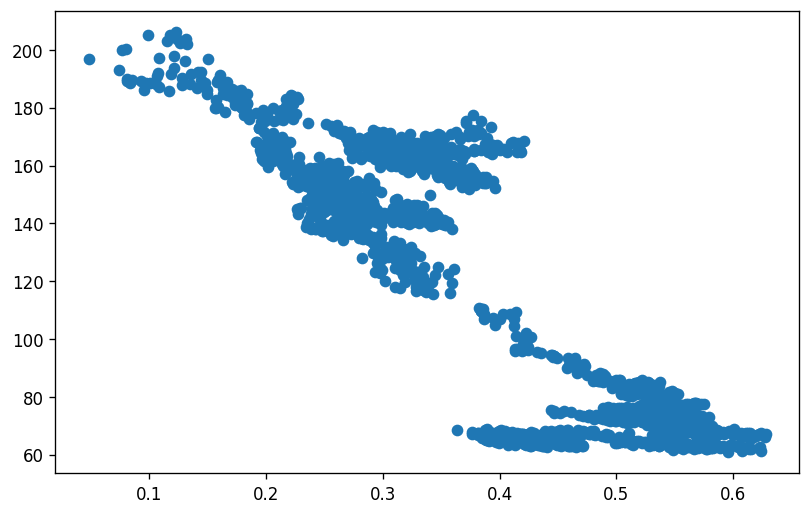

In [58]:
plt.scatter(x_train, y_train)

Кажется, здесь может подойти линейная регресия

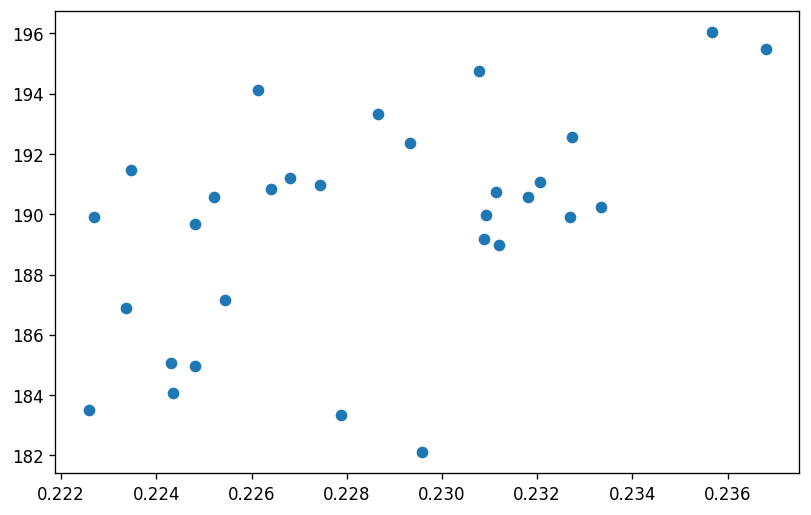

In [59]:
# Это нужно предсказать, последние 30 дней
plt.scatter(x_test, y_test)

### Линейная регрессия. Предсказание USD/RUB от котировок на нефть

In [60]:
from sklearn.linear_model import LinearRegression

In [61]:
lin_reg = LinearRegression()

In [62]:
lin_reg.fit(x_train, y_train)

LinearRegression()

In [63]:
lin_reg.predict(x_test)

In [64]:
y_test

### Посмотрим на ошибки

### MAE

In [65]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_train, lin_reg.predict(x_train))

14.3728575226197

In [66]:
mean_absolute_error(y_test, lin_reg.predict(x_test))

23.355641815964926

### MAPE

In [67]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(y_test, lin_reg.predict(x_test))

0.12273850381288945

In [68]:
mean_absolute_percentage_error(y_train, lin_reg.predict(x_train))

0.14048173459788532

В нашем случае относительная ошибка имеет интуитивно понятный смысл и значение, в отличие от других метрик.

### Предсказание курса по предсказанным нефтяным котировкам

Теперь попробуем предсказать usd/rub по нашим предсказанным значениям котировок нефти в предыдущем пункте

In [69]:
predicted_with_oil_forecasts = lin_reg.predict(np.array(np.exp(fc[:-1]).to_list()).reshape(-1, 1))

In [70]:
mean_absolute_percentage_error(y_test, predicted_with_oil_forecasts)

0.12219497004064116

### Вывод

Таким образом, получаем, что средняя относительная ошибка не превосходит 13%, для предсказаний на будущие 30 дней по заранее предсказанным значениям нефтяных котировок с помощью модели ARIMA(p, d, q) = ARIMA(1, 0, 1)